## 基于单树GP的符号回归（Symbolic Regression）

基于单树GP的符号回归是指使用遗传编程（GP）生成数学公式来逼近一组数据的关系，通过组合DEAP的Creator，Toolbox和Algorithms这三个模块即可实现。


### Creator类
Creator是一个工具类，其主要作用是创建新的类。在遗传编程中，通常需要自定义个体（Individual）和适应度（Fitness）类，因为不同的问题可能需要不同的适应度类型和个体结构。在DEAP中，我们可以使用creator来动态地创建这些类。

在下面的例子中，我们创建了一个最基本的单目标单树GP，可以使用base.Fitness和gp.PrimitiveTree来定义。

In [1]:
import math
import operator # 提供基本数学运算符

from deap import base, creator, tools, gp


# 符号回归
# 评估函数，输入一个个体individual和一个原语集pset
def evalSymbReg(individual, pset):
    # 编译GP树为函数
    func = gp.compile(expr=individual, pset=pset)
    # 计算均方误差（Mean Square Error，MSE）
    mse = ((func(x) - x**2)**2 for x in range(-10, 10))
    return (math.fsum(mse),)

# 创建个体和适应度函数
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
"""
创建了一个名为FitnessMin的新类，它继承自base.Fitness类
weights=(-1.0,) 表示这是一个最小化问题，如果是(1.0,)则表示最大化问题
-1.0意味着适应度值越小越好
括号和逗号(-1.0,)表示这是一个单目标优化问题
"""
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)
"""
创建了一个名为Individual的新类
它继承自gp.PrimitiveTree类（这是遗传编程中表示表达式树的类）
fitness=creator.FitnessMin给这个类添加了一个适应度属性
"""

'\n创建了一个名为Individual的新类\n它继承自gp.PrimitiveTree类（这是遗传编程中表示表达式树的类）\nfitness=creator.FitnessMin给这个类添加了一个适应度属性\n'

这里需要有些注释：

1. 原语集(pset)：原语集就是我们定义的所有可用的基本操作和变量,在这个例子中包含:
- 数学运算: +, -, ×, 负号
- 变量: x
- 常量: -1, 0, 1

2. 个体(individual)是用这些基本原语（元素）构建出来的一个表达式树。比如:

假设进化过程生成了表达式: `x × (x + 1)`

这个表达式作为一个个体,它的树形结构是这样的:
```
      ×
     / \
    x   +
       / \
      x   1
```

那么评估函数的工作就是:
```python
def evalSymbReg(individual, pset):
    # 把表达式树编译成实际的函数
    func = gp.compile(expr=individual, pset=pset)
    # 现在func相当于: f(x) = x * (x + 1)
    
    # 计算在x从-10到9的每个点上的误差
    mse = ((func(x) - x**2)**2 for x in range(-10, 10))
    # 例如:
    # 当x = 2时:
    # func(2) = 2 * (2 + 1) = 2 * 3 = 6
    # 实际值 2² = 4
    # 误差 = (6 - 4)² = 4
    
    return (math.fsum(mse),)  # 返回总误差
```

评估函数会对每个这样的个体:
- 把它编译成可执行的数学函数
- 用不同的x值(-10到9)测试这个函数
- 计算与目标函数(x²)的误差
- 返回总误差作为这个个体的适应度

适应度越小说明这个表达式越接近我们要找的x²函数。进化过程就是不断尝试不同的表达式组合,保留误差小的,淘汰误差大的,最终找到一个好的近似表达式。

3. 创建个体的过程可以如下简化：

```python
某个个体 = Individual(一个表达式树)
某个个体.fitness.values = (100,)  # 设置这个个体的适应度值

# 具体例子：如果这个个体表示表达式 x * (x + 1)
个体的树形结构 = [
    operator.mul,   # 乘法操作
    'x',           # 变量x
    [              # 子树
        operator.add,  # 加法操作
        'x',          # 变量x
        1             # 常数1
    ]
]
individual = Individual(个体的树形结构)
individual.fitness.values = (50,)  # 设置适应度
```

### Toolbox类
Toolbox的作用类似于一个调度中心，它负责“注册”各种操作和函数。在遗传编程中，这些操作通常包括交叉（crossover）、变异（mutation）、选择（selection）和评估（evaluation）。通过register，我们可以将这些操作和相关的函数绑定在一起，以供后续算法使用。

In [2]:
import random

# 定义函数集合和终端集合
pset = gp.PrimitiveSet("MAIN", arity=1) # 创建一个原语集，arity=1表示需要1个输入变量
pset.addPrimitive(operator.add, 2) # +
pset.addPrimitive(operator.sub, 2) # -
pset.addPrimitive(operator.mul, 2) # *
pset.addPrimitive(operator.neg, 1) # 取负
pset.addEphemeralConstant("rand101", lambda: random.randint(-1, 1)) # 添加一个随机常数生成器，可以生成-1、0、1这三个数。每次用到这个常数时，都会随机选择一个。
pset.renameArguments(ARG0='x') # 把默认的参数名ARG0改成x，使表达式更易读。

# 定义遗传编程操作
toolbox = base.Toolbox() # 创建一个新的工具箱，用于存放各种操作。
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2) # 注册表达式生成器，使用"Half and Half"方法，树的深度在1到2之间。
"""
例如可能生成：
    +            ×
   / \    或    / \
  x   1        x   x
"""
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr) # 注册个体生成器，使用上面的表达式生成器创建个体。
toolbox.register("population", tools.initRepeat, list, toolbox.individual) # 注册种群生成器，通过重复创建个体来形成种群。
toolbox.register("compile", gp.compile, pset=pset) # 注册编译器，用于把表达式树转换成可执行函数。
toolbox.register("evaluate", evalSymbReg, pset=pset) # 注册评估函数，用于计算个体的适应度（本例越小越好）。
toolbox.register("select", tools.selTournament, tournsize=3) # 注册选择操作，使用锦标赛选择：随机选3个个体，取最好的那个。
toolbox.register("mate", gp.cxOnePoint) # 注册交叉操作，用于组合两个父代个体生成子代。
"""
例如：
父代1: (x + 1)     父代2: (x * x)
交叉后可能得到：
子代1: (x * 1)     子代2: (x + x)
"""
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr, pset=pset) # 注册变异操作，随机改变表达式的某个部分。
"""
例如：
原始: (x + 1)
变异后: (x * 1) 或 (x + x) 等
"""

/home/glk/project/anaconda3/lib/python3.11/site-packages/deap/gp.py:257: RuntimeWarning: Ephemeral rand101 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


'\n例如：\n原始: (x + 1)\n变异后: (x * 1) 或 (x + x) 等\n'

### Algorithms类
Algorithms模块提供了一些现成的遗传算法和遗传编程的实现。例如，eaSimple是一个简单的遗传算法，它可以处理基本的选择、交叉、变异和演化迭代。

In [3]:
import numpy
from deap import algorithms

# 定义统计指标
stats_fit = tools.Statistics(lambda ind: ind.fitness.values) # 创建统计对象来跟踪个体的适应度，lambda ind: ind.fitness.values 匿名函数从每个个体中提取适应度值
stats_size = tools.Statistics(len) # 创建统计对象来跟踪个体的大小（表达式的复杂度）
"""
例如：
x + 1 大小为3（一个加号，两个终端）
x * (x + 1) 大小为5
"""
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size) # 把适应度统计和大小统计组合在一起。
mstats.register("avg", numpy.mean) # 平均值
mstats.register("std", numpy.std) # 标准差
mstats.register("min", numpy.min) # 最小值
mstats.register("max", numpy.max) # 最大值

# 使用默认算法
population = toolbox.population(n=100) # 生成100个随机个体作为初始种群。
hof = tools.HallOfFame(1) # 名人堂，用来保存找到的最佳个体。这里设置为1表示只保存最好的那一个。
pop, log  = algorithms.eaSimple( # 运行进化算法
    population=population,  # 初始种群
    toolbox=toolbox,  # 工具箱
    cxpb=0.9,  # 交叉概率90%
    mutpb=0.1, # 变异概率10%
    ngen=10, # 进化10代
    stats=mstats, # 统计对象
    halloffame=hof, # 名人堂
    verbose=True, # 调试模式
    )


   	      	                              fitness                              	                      size                     
   	      	-------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg        	gen	max       	min	nevals	std        	avg 	gen	max	min	nevals	std    
0  	100   	2.33643e+06	0  	2.2959e+08	0  	100   	2.28398e+07	3.72	0  	7  	2  	100   	1.59424
1  	92    	68018.2    	1  	3.19748e+06	0  	92    	315074     	3.11	1  	7  	2  	92    	1.24816
2  	94    	65211.2    	2  	3.51947e+06	0  	94    	348146     	3.25	2  	11 	2  	94    	1.76281
3  	96    	86640.9    	3  	3.19748e+06	0  	96    	445510     	3.85	3  	9  	2  	96    	1.82414
4  	98    	2.43247e+06	4  	2.24174e+08	0  	98    	2.23227e+07	3.66	4  	10 	2  	98    	1.53766
5  	92    	126027     	5  	1.22679e+07	0  	92    	1.22044e+06	3.08	5  	7  	3  	92    	0.462169
6  	85    	34482.8    	6  	3.19748e+06	0  	85    	318048     	3.12	6  	9  	3  	85    	0.6

分析上述输出结果：这是进化过程中每一代的统计数据，分为fitness（适应度）和size（大小）两部分：

按代分析：

第0代（初始种群）：
```
fitness:
- 平均值(avg): 2.33643e+06 （非常大的误差）
- 最大值(max): 2.2959e+08 （最差的个体）
- 最小值(min): 0 （最好的个体）
- 标准差(std): 2.28398e+07 （说明个体差异很大）

size:
- 平均大小(avg): 3.72
- 最大大小(max): 7
- 最小大小(min): 2
- 标准差(std): 1.59424 （表达式大小的变化范围）
```

第10代（最终代）：
```
fitness:
- 平均值(avg): 8560.06 （误差显著降低）
- 最大值(max): 162664 （最差个体的误差）
- 最小值(min): 0 （找到了完美拟合的解）
- 标准差(std): 32565.4 （个体间的差异减小）

size:
- 平均大小(avg): 3.3
- 最大大小(max): 9
- 最小大小(min): 2
- 标准差(std): 0.974679 （表达式大小更稳定）
```

进化趋势分析：

1. 适应度改进:
   - 从初代的平均误差233万降到最后的8560
   - 表明表达式的拟合效果有显著提升
   - 最后找到了误差为0的完美解

2. 表达式大小变化:
   - 平均大小基本稳定在3-4之间
   - 没有出现表达式爆炸（变得过于复杂）
   - 标准差从1.59降到0.97，说明大小更加统一

3. 关键转折点:
   - 第1-2代：适应度有大幅改善
   - 第6-7代：又一次显著进步
   - 第8-10代：性能趋于稳定

4. 种群规模:
   - nevals显示每代评估的个体数在85-100之间
   - 说明保持了足够的多样性

总结：
1. 算法成功找到了完美解（fitness=0）
2. 进化过程是有效的，误差持续降低
3. 表达式保持了简洁性（size较小且稳定）
4. 最终解既准确（fitness=0）又简单（size较小）

这是一次成功的运行，因为：
- 达到了最优适应度（0误差）
- 保持了表达式的简洁性
- 显示了清晰的进化改进过程

由于DEAP重载了字符串运算符，因此可以直接输出结果。

In [4]:
str(hof[0]) # 名人堂只有一个

'mul(x, x)'

当然，我们也可以利用NetworkX库来对GP树进行可视化。

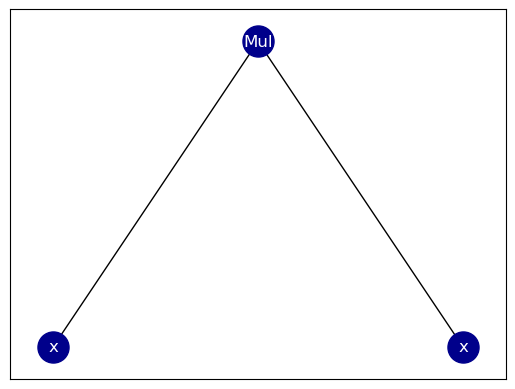

In [5]:
# sudo apt-get install graphviz graphviz-dev
# pip install pygraphviz
import networkx as nx
from deap.gp import graph
from networkx.drawing.nx_agraph import graphviz_layout

function_name = {
    'add':'Add',
    'sub':'Sub',
    'mul':'Mul',
    'neg':'Neg'
}

def is_number(string):
    try:
        float(string)
        return True
    except ValueError:
        return False


def plot_a_tree(tree=hof[0]):
    red_nodes = []
    purple_nodes = []
    blue_nodes = []
    for gid, g in enumerate(tree):
        if (
                hasattr(g, "value")
                and isinstance(g.value, str)
                and g.value.startswith("ARG")
        ):
            g.value = g.value.replace("ARG", "X")

        if g.name in function_name:
            g.name = function_name[g.name]

        if hasattr(g, "value") and (
                is_number(g.value)
                or (g.value.startswith("X") and int(g.value[1:]) < X.shape[1])
        ):
            # 基础节点
            red_nodes.append(gid)
        elif hasattr(g, "value") and g.value.startswith("X"):
            g.value = "$\phi$" + str(int(g.value.replace("X", "")) - X.shape[1] + 1)
            purple_nodes.append(gid)
        elif hasattr(g, "value") and g.value.startswith("$\phi$"):
            purple_nodes.append(gid)
        else:
            # 深蓝色节点
            blue_nodes.append(gid)
    nodes, edges, labels = graph(tree)
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    pos = graphviz_layout(g, prog="dot")
    red_nodes_idx = [nodes.index(n) for n in nodes if n in red_nodes]
    purple_nodes_idx = [nodes.index(n) for n in nodes if n in purple_nodes]
    blue_nodes_idx = [nodes.index(n) for n in nodes if n in blue_nodes]
    nx.draw_networkx_nodes(
        g, pos, nodelist=red_nodes_idx, node_color="darkred", node_size=500
    )
    nx.draw_networkx_nodes(
        g, pos, nodelist=purple_nodes_idx, node_color="indigo", node_size=500
    )
    nx.draw_networkx_nodes(
        g, pos, nodelist=blue_nodes_idx, node_color="darkblue", node_size=500
    )
    nx.draw_networkx_edges(g, pos)
    nx.draw_networkx_labels(g, pos, labels, font_color="white")


plot_a_tree(hof[0])